In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"trythse3k3r","key":"ceab88d17ac74170ecf8c829f0841a18"}'}

In [ ]:
!ls

'kaggle (1).json'   model.pt	  signature-verification-dataset.zip
 kaggle.json	    sample_data   sign_data


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d robinreni/signature-verification-dataset

 97% 585M/601M [00:07<00:00, 95.2MB/s]
100% 601M/601M [00:07<00:00, 88.0MB/s]


In [ ]:
from zipfile import ZipFile
file_name="signature-verification-dataset.zip"
with ZipFile(file_name,'r')as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import numpy as np 
import pandas as pd 
import os

In [ ]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import random
from PIL import Image
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
train_dir="/content/sign_data/train"
train_csv="/content/sign_data/train_data.csv"
test_csv="/content/sign_data/test_data.csv"
test_dir="/content/sign_data/test"

In [ ]:
df_train=pd.read_csv(train_csv)
df_train.sample(10)

,068/09_068.png,068_forg/03_0113068.PNG,1
3893,014/014_02.PNG,014_forg/0214014_02.png,1
22826,066/11_066.png,066_forg/02_0127066.PNG,1
19179,042/11_042.png,042/01_042.png,0
3886,014/014_02.PNG,014_forg/0208014_02.png,1
11580,051/08_051.png,051_forg/03_0104051.PNG,1
11045,003/003_06.PNG,003/003_24.PNG,0
14724,016/016_04.PNG,016/016_09.PNG,0
5871,022/11_022.png,022/10_022.png,0
2849,004/004_02.PNG,004/004_15.PNG,0
10331,067/05_067.png,067/11_067.png,0


In [ ]:
df_test=pd.read_csv(test_csv)
df_test.sample(10)

,068/09_068.png,068_forg/03_0113068.PNG,1
4590,056/09_056.png,056/01_056.png,0
799,058/04_058.png,058/03_058.png,0
1287,051/04_051.png,051_forg/04_0120051.PNG,1
1025,065/11_065.png,065/05_065.png,0
2861,069/08_069.png,069/04_069.png,0
5135,064/07_064.png,064/09_064.png,0
2045,055/04_055.png,055/12_055.png,0
4378,063/07_063.png,063/04_063.png,0
3649,052/02_052.png,052_forg/03_0207052.PNG,1
4735,059/03_059.png,059_forg/01_0104059.PNG,1


In [ ]:
class Dataset(Dataset):
    #default constuctor for assigning values
    def __init__(self,train_dir=None,train_csv=None,transform=None):
        self.train_dir=train_dir
        self.train_data=pd.read_csv(train_csv)
        self.train_data.columns=['image1','image2','class']
        self.transform=transform
        
    def __getitem__(self,idx): ## __getitem__ returns a sample data given index, idx=index
        
        img1_path=os.path.join(self.train_dir,self.train_data.iat[idx,0])
        img2_path=os.path.join(self.train_dir,self.train_data.iat[idx,1])
        
        img1=Image.open(img1_path)
        img2=Image.open(img2_path)
        
        img1=img1.convert('L') #L mode image, that means it is a single channel image - normally interpreted as greyscale.
        img2=img2.convert('L')
        
        img1=self.transform(img1)
        img2=self.transform(img2)
        return img1, img2, torch.from_numpy(np.array([int(self.train_data.iat[idx,2])],dtype=np.float32))
    
    
    def __len__(self): ## __len__ returns the size of the dataset..
        return len(self.train_data)

In [ ]:
dataset = Dataset(train_dir,train_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))

In [ ]:
dataset

In [ ]:
class SiameseNetwork(nn.Module):
    
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        
        self.conv1=nn.Conv2d(1,50,kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
         # L1 ImgIn shape=(?, 28, 28, 1)      # (n-f+2*p/s)+1
        #    Conv     -> (?, 24, 24, 50)
        #    Pool     -> (?, 12, 12, 50)
        
        
        self.conv2 = nn.Conv2d(50,60, kernel_size = 5)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        # L2 ImgIn shape=(?, 12, 12, 50)
        #    Conv      ->(?, 8, 8, 60)
        #    Pool      ->(?, 4, 4, 60)
        self.conv3 = nn.Conv2d(60, 80,  kernel_size = 3)
        # L3 ImgIn shape=(?, 4, 4, 60)
        #    Conv      ->(?, 2, 2, 80)
       
        
        
        self.batch_norm1 = nn.BatchNorm2d(50)
        self.batch_norm2 = nn.BatchNorm2d(60)
        
#         self.dropout1 = nn.Dropout2d()
        
        # L4 FC 2*2*80 inputs -> 250 outputs
        self.fc1 = nn.Linear(32000, 128) 
        self.fc2 = nn.Linear(128, 2)
        
      
    
    
    def forward1(self,x):
        x=self.conv1(x)
        x = self.batch_norm1(x)
        x=F.relu(x)
        x=self.pool1(x)
        
        x=self.conv2(x)
        x = self.batch_norm2(x)
        x=F.relu(x)
        x=self.pool2(x)
        
        x=self.conv3(x)
        x=F.relu(x)
#         print(x.size())
        x = x.view(x.size()[0], -1)
#         print('Output2')
#         print(x.size()) #32000 thats why the input of fully connected layer is 32000
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward1(input1)
        # forward pass of input 2
        output2 = self.forward1(input2)
        
        return output1, output2


In [ ]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=1.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
train_dataloader = DataLoader(dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=32)

In [ ]:
train_dataloader

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
net = SiameseNetwork().cuda()

criterion = ContrastiveLoss()               
optimizer = torch.optim.SGD(net.parameters(), lr = 3e-4) 

optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99)

In [ ]:
def train():
    loss= [] 

    for epoch in range(1,10):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            
        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))

        loss.append(loss_contrastive.item())
        
    return net

In [ ]:
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

Epoch 1
 Current loss 0.7899448275566101

Epoch 2
 Current loss 0.4314520061016083

Epoch 3
 Current loss 0.4830187261104584

Epoch 4
 Current loss 0.592597484588623

Epoch 5
 Current loss 0.6160428524017334

Epoch 6
 Current loss 0.5876047611236572

Epoch 7
 Current loss 0.4518934488296509

Epoch 8
 Current loss 0.7394447326660156

Epoch 9
 Current loss 0.7361137866973877

Model Saved Successfully


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [ ]:
test_dataset = Dataset(test_dir,test_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))

test_dataloader = DataLoader(test_dataset,num_workers=8,batch_size=1,shuffle=True)

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

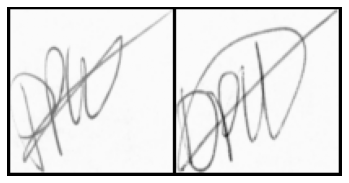

Predicted Eucledian Distance:- 0.6321431398391724
Actual Label:- Forged Pair Of Signature


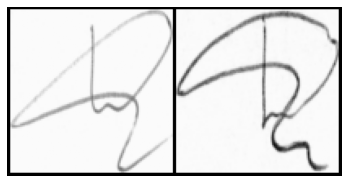

Predicted Eucledian Distance:- 1.1672464609146118
Actual Label:- Forged Pair Of Signature


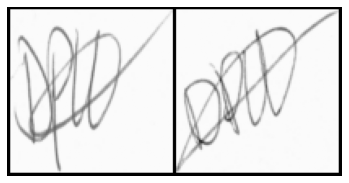

Predicted Eucledian Distance:- 0.9421533942222595
Actual Label:- Forged Pair Of Signature


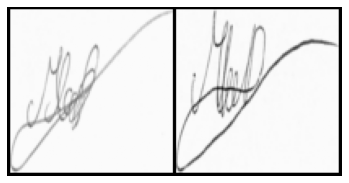

Predicted Eucledian Distance:- 0.9829225540161133
Actual Label:- Forged Pair Of Signature


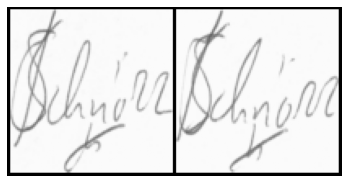

Predicted Eucledian Distance:- 0.6743181943893433
Actual Label:- Original Pair Of Signature


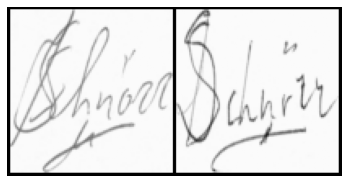

Predicted Eucledian Distance:- 0.9637246131896973
Actual Label:- Forged Pair Of Signature


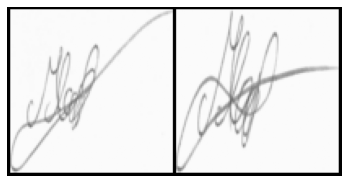

Predicted Eucledian Distance:- 0.3122096061706543
Actual Label:- Original Pair Of Signature


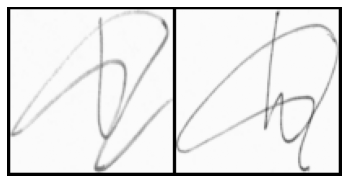

Predicted Eucledian Distance:- 0.7280720472335815
Actual Label:- Forged Pair Of Signature


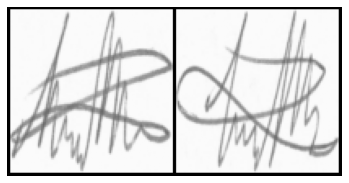

Predicted Eucledian Distance:- 0.1408775895833969
Actual Label:- Original Pair Of Signature


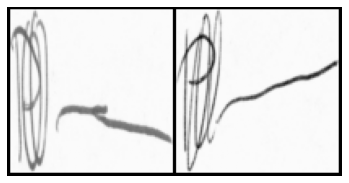

Predicted Eucledian Distance:- 0.46986058354377747
Actual Label:- Forged Pair Of Signature


In [ ]:
count=0
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concat = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))

  eucledian_distance = F.pairwise_distance(output1, output2)
    
  if label==torch.FloatTensor([[0]]):
    label="Original Pair Of Signature"
  else:
    label="Forged Pair Of Signature"
    
  imshow(torchvision.utils.make_grid(concat))
  print("Predicted Eucledian Distance:-",eucledian_distance.item())
  print("Actual Label:-",label)
  count=count+1
  if count ==10:
     break